1. define X,y
2. split train & validation dataset
3. modeling
4. model 해석

In [1]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe() #censor is target

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [4]:
# Data Quality Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (532, 22)


In [5]:
drop_col

10    zprior
Name: name, dtype: object

In [6]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [7]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[LightGBM Parameters]
  - Package : https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
  - learning_rate : GBM에서 shrinking 하는 것과 같은 것
  - reg_lambda : L2 regularization term on weights (analogous to Ridge regression)
  - reg_alpha : L1 regularization term on weight (analogous to Lasso regression)
  - objective 
        objective 🔗︎, default = regression, type = enum, options: regression, regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda, lambdarank, rank_xendcg, aliases: objective_type, app, application, loss

  - eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        -    rmse – root mean square error
        -    mae – mean absolute error
        -    logloss – negative log-likelihood
        -    error – Binary classification error rate (0.5 threshold)
        -    merror – Multiclass classification error rate
        -    mlogloss – Multiclass logloss
        -    auc: Area under the curve

[LightGBM]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - LightGBM은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음

In [8]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMClassifier(n_estimators=n, learning_rate=l, 
                                       max_depth=m, reg_alpha=L1, 
                                       n_jobs=-1, objective='cross_entropy')
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])
                
                
                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))


                #joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 372.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 20
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.352151 -> initscore = -0.609600
[LightGBM] [Info] Start training from score -0.609600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Test Confusion Matrix
[[94 16]
 [ 5 45]]
TesT Acc : 0.86875
Test F1-Score : 0.8108108108108109
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 11 <<<
n_estimators : 5, learning_rate : 0.3, max_depth : 5, reg_alpha : 0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 372.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train Confusion Matrix
[[229  12]
 [ 10 121]]
Train Acc : 0.9408602150537635
Train F1-Score : 0.9166666666666667
Test Confusion Matrix
[[92 18]
 [ 1 49]]
TesT Acc : 0.88125
Test F1-Score : 0.8376068376068375
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 20 <<<
n_estimators : 10, learning_rate : 0.3, max_depth : 3, reg_alpha : 0.5
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 372.000000
[LightGBM] [Info] Auto-ch

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [9]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)], 
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))

>>> 7 <<<
Best Test f1-score : 0.8672566371681417
Best n_estimators : 5
Best Learning Rate : 0.3
Best Max_depth : 3
Best L1-norm : 0.3


In [10]:
best_model = LGBMClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)], 
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='cross_entropy', 
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 372.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 20
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.352151 -> initscore = -0.609600
[LightGBM] [Info] Start training from score -0.609600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train Confusion Matrix
[[228

In [11]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

    Score  Feature
0      10    event
1       4    cd496
2       4    cd420
3       4     cd40
4       3  preanti
5       2     wtkg
6       2     race
7       1      z30
8       1      age
9       0  symptom
10      0    strat
11      0     str2
12      0        r
13      0   oprior
14      0   karnof
15      0     homo
16      0     hemo
17      0   gender
18      0    drugs
19      0    cd820
20      0     cd80


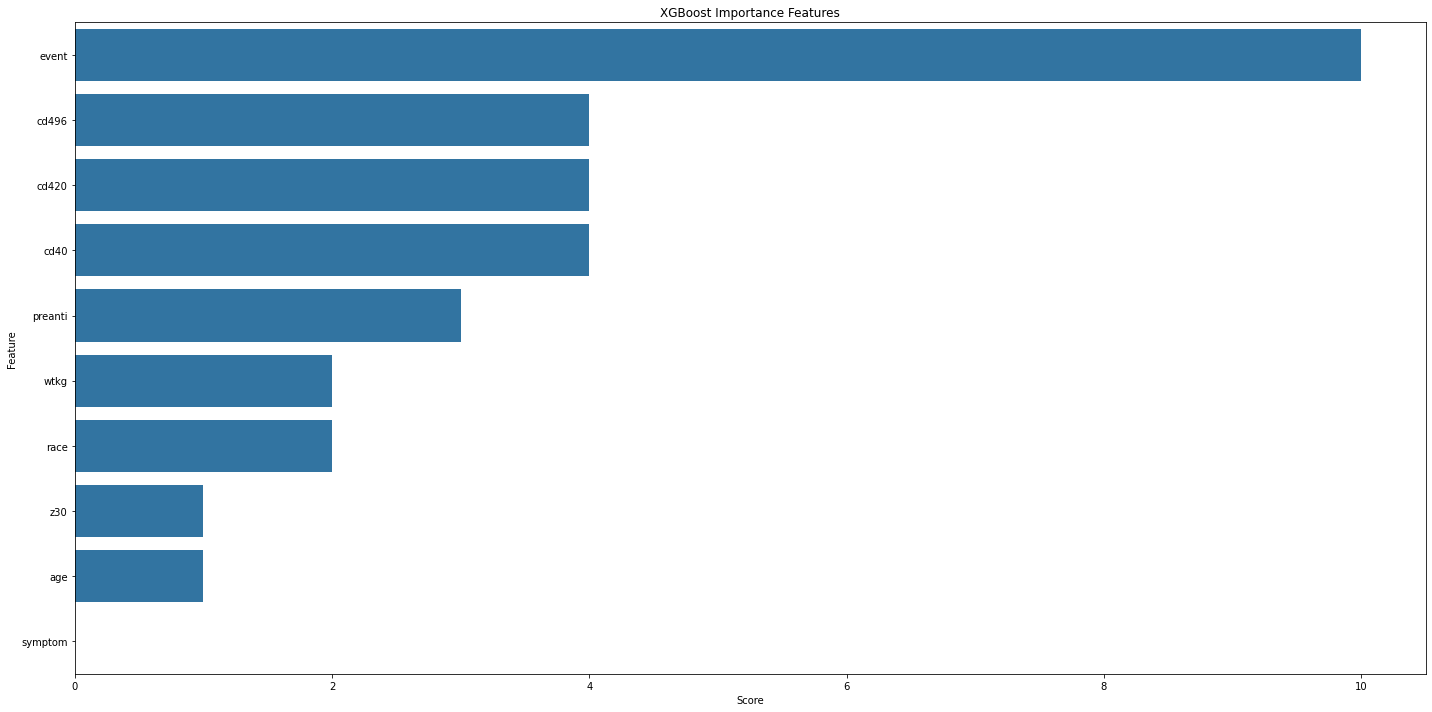

In [12]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()